In [1]:

import numpy as np
import astropy.units as u
from astropy.io import fits

import scoobpsf
import scoobpsf.compact_scoob as scoob
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from scipy.optimize import minimize

npix = 1000
wavelength = 650e-9*u.m
pupil_diam = 9.4*u.mm
scc_sep = 5.5*u.mm


# Establish the forward model and the relavent EFC parameters for simulation.

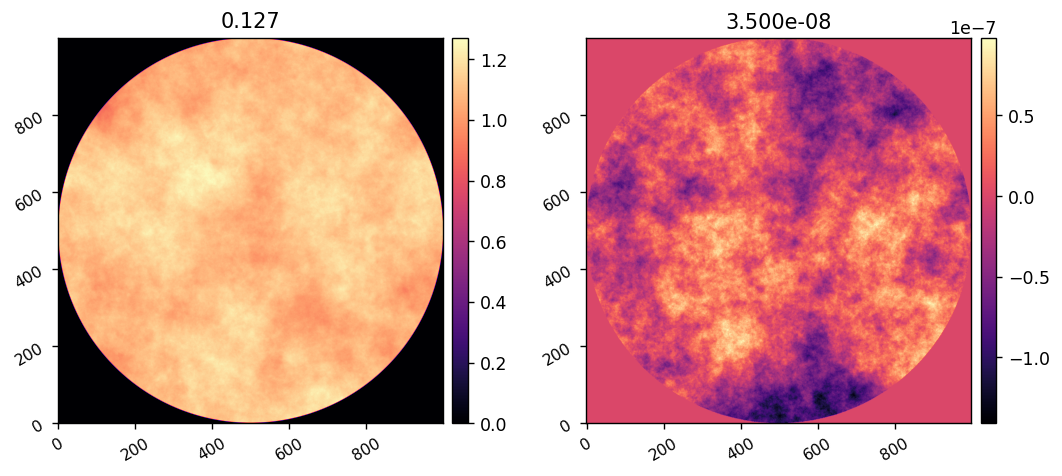

In [2]:
reload(utils)
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

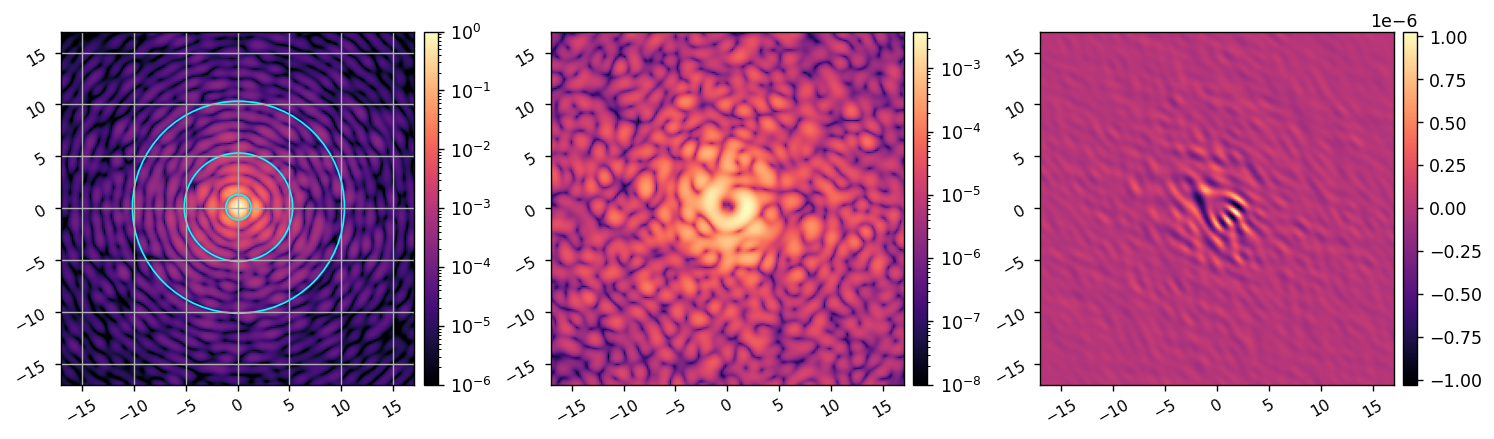

In [3]:
reload(scoob)
model = scoob.CORO()
model.scc_diam = 50*u.um
model.scc_pinhole_position = (scc_sep/np.sqrt(2), scc_sep/np.sqrt(2))

model.WFE = WFE
ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

model.use_fpm = True

ref_im = model.snap()

model.use_scc()
scc_im = model.snap()
model.use_scc(False)

imshow3(ref_psf/model.Imax_ref, ref_im, ref_im - scc_im, 
        lognorm1=True, lognorm2=True, vmin1=1e-6, vmin2=1e-8,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+4, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+9, fill=False, color='cyan')])

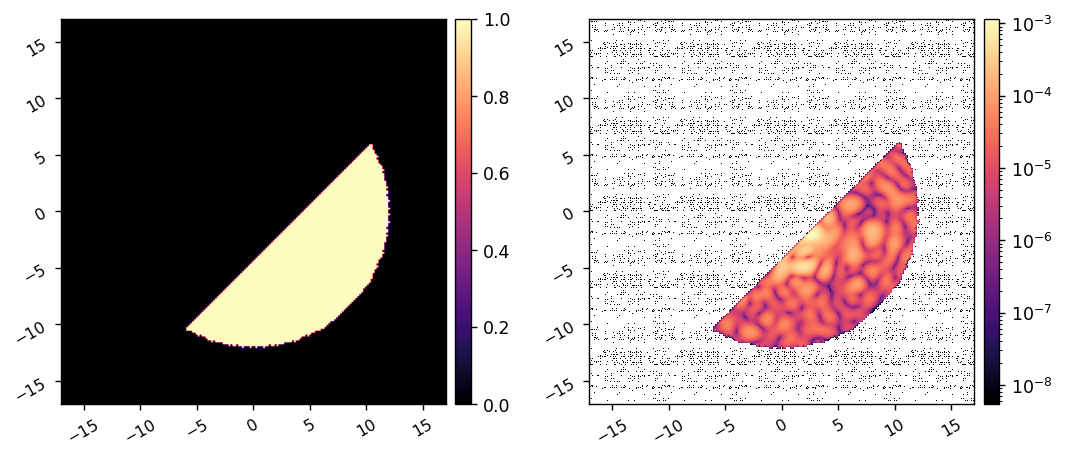

In [4]:
reload(lina.utils)
control_mask = lina.utils.create_annular_focal_plane_mask(model, 3, 12, 3, rotation=45)
imshow2(control_mask, ref_im*control_mask, lognorm2=True, pxscl=model.psf_pixelscale_lamD)


# Create the adjoint model to back propagate 

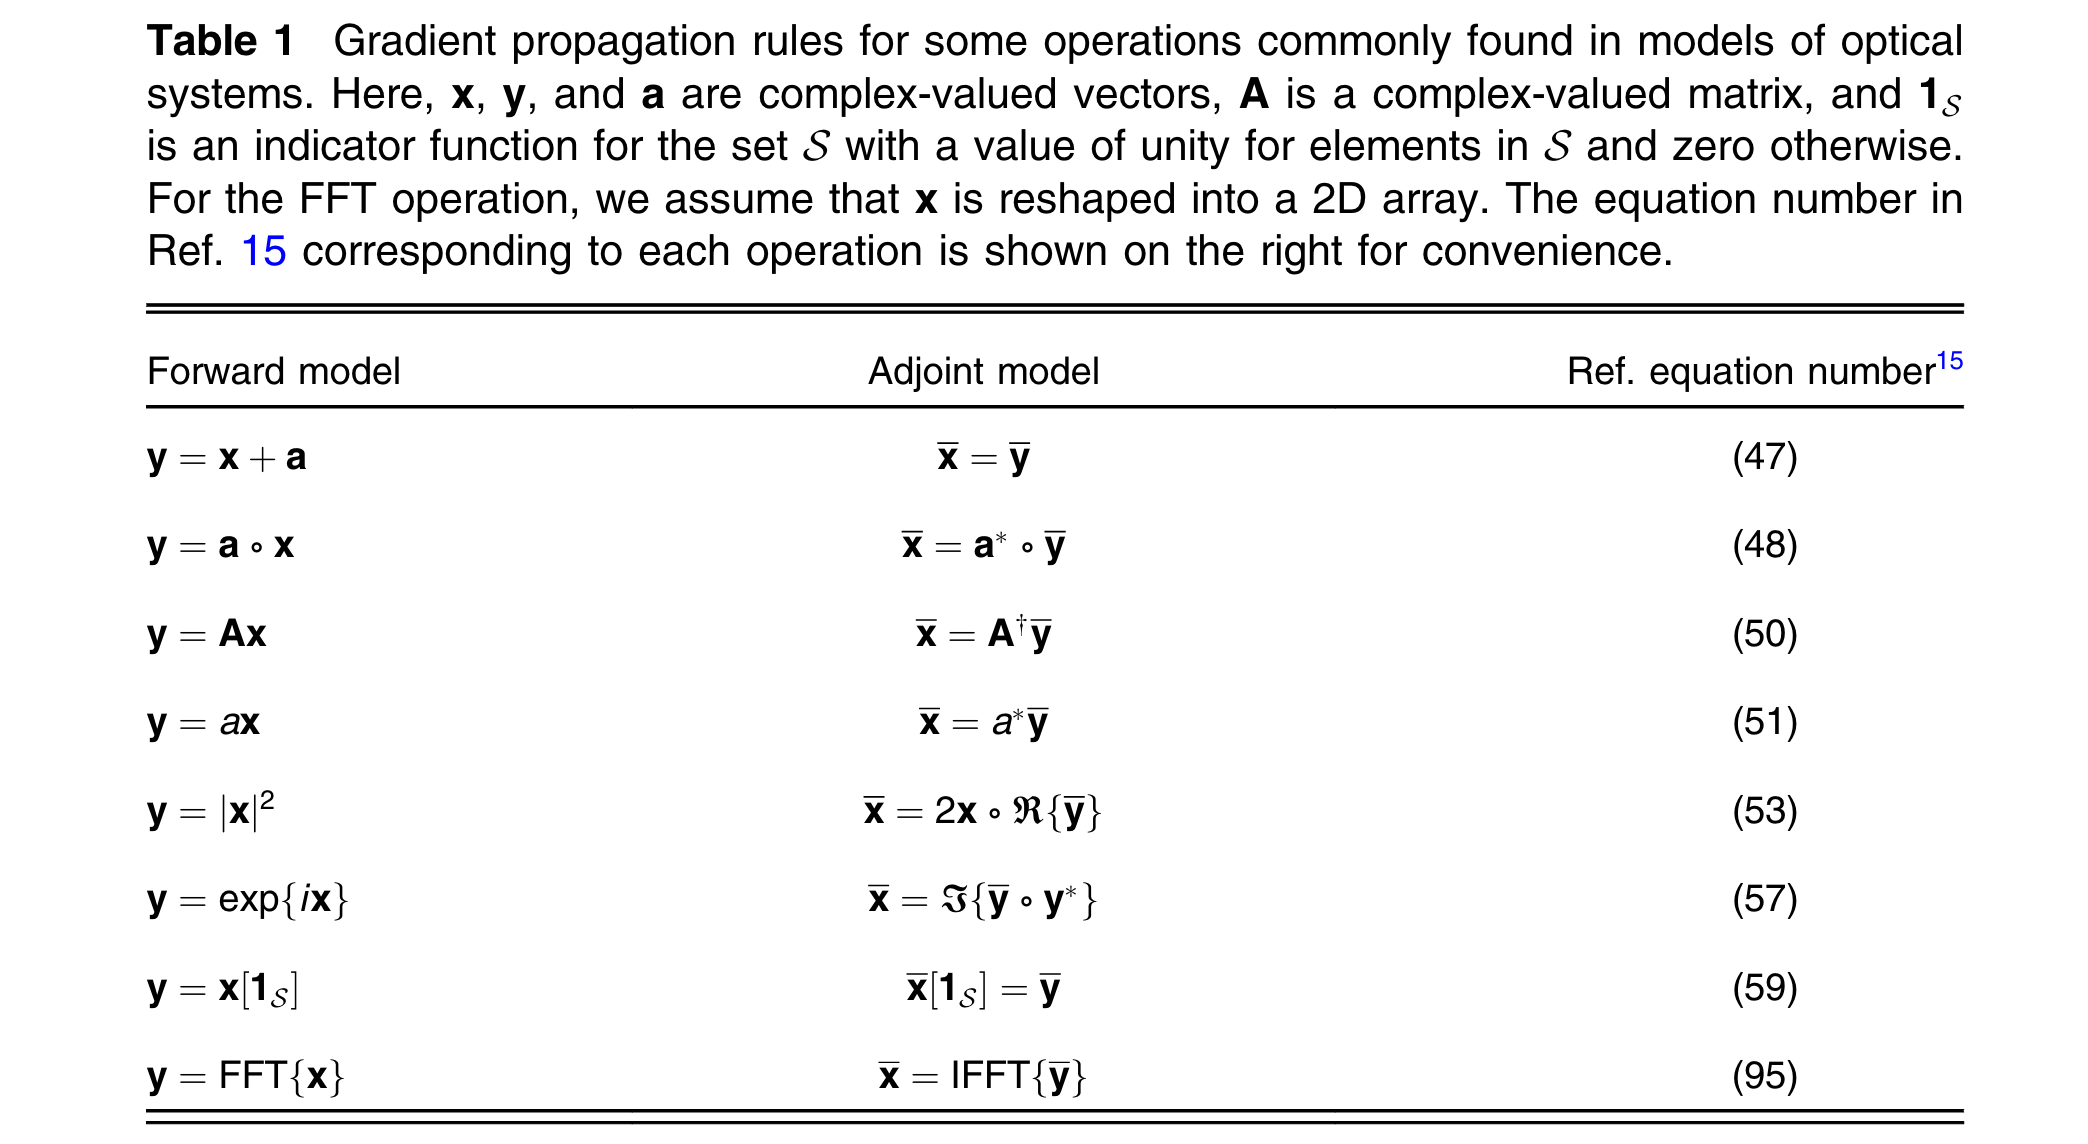